<a href="https://colab.research.google.com/github/sujishna/J-notebook/blob/main/minipro_sale_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

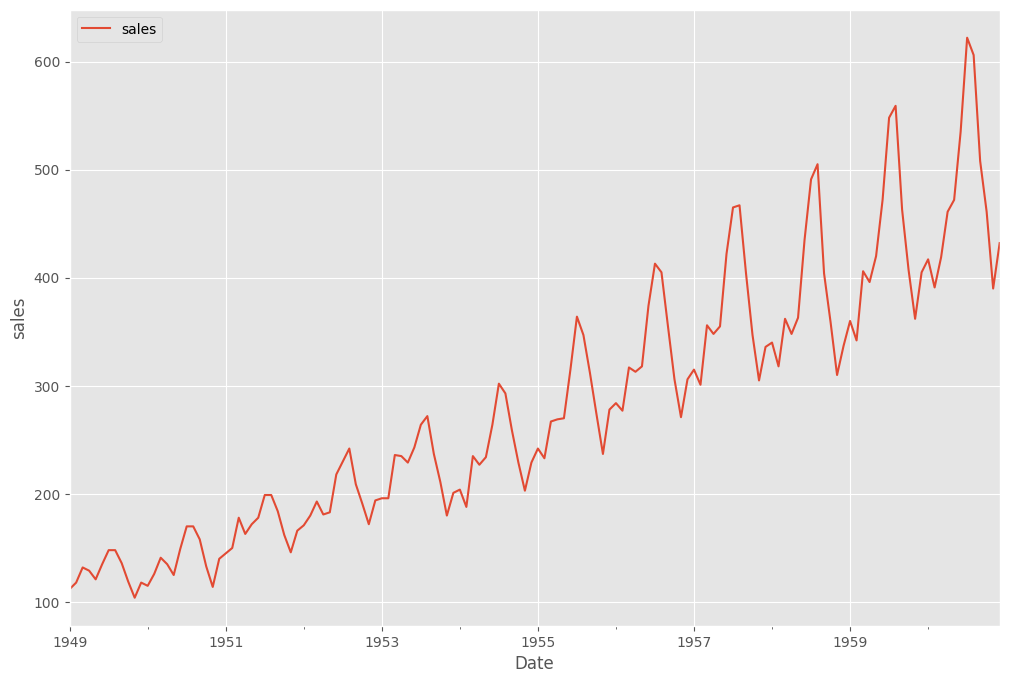

In [ ]:
# Load the data
data = pd.read_csv('/content/international-airline-passengers.csv', engine='python', skipfooter=3)#change to input data if it is function

#pre processing
data.columns=['Month','sales']

# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d')
data.set_index(['Month'], inplace=True)


# Plot the data
data.plot()
plt.ylabel('sales')
plt.xlabel('Date')
plt.show()

In [ ]:
# Define the d and q parameters to take any value between 0 and 1 p- auto regressive terms, q-sesonal differenncing,d-movin average
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
train_data = data['1949-01-01':'1959-12-01']  #changes in the value of date
test_data = data['1960-01-01':'1960-12-01']

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [ ]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC),
       SARIMAX_model[AIC.index(min(AIC))][0],
       SARIMAX_model[AIC.index(min(AIC))][1]
      ))

The smallest AIC is 618.2055112554506 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [ ]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()


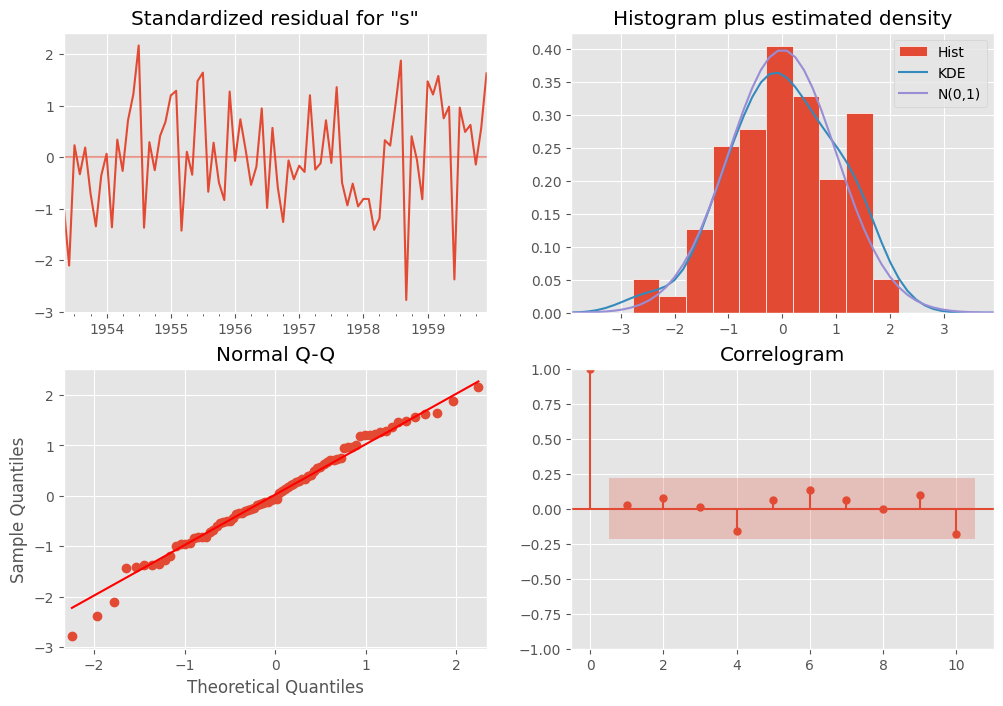

In [ ]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

<Axes: xlabel='Month'>

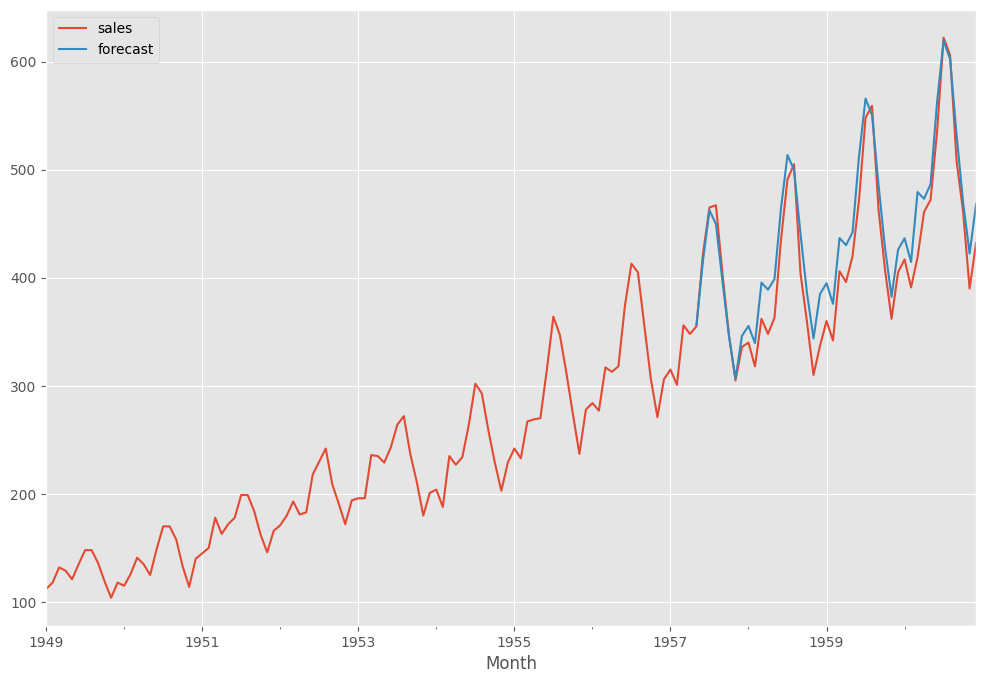

In [ ]:
data['forecast']=results.predict(start=100,end=150,dynamic=True)
data[['sales','forecast']].plot(figsize=(12,8))

In [ ]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)#predictions date values will change
pred0_ci = pred0.conf_int()
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])


1960-01-01    419.494621
1960-02-01    397.833761
1960-03-01    460.858875
1960-04-01    449.451491
1960-05-01    474.555499
1960-06-01    537.848734
1960-07-01    614.884698
1960-08-01    628.209090
1960-09-01    519.336199
1960-10-01    462.254385
1960-11-01    412.163869
1960-12-01    452.664452
Freq: MS, Name: predicted_mean, dtype: float64


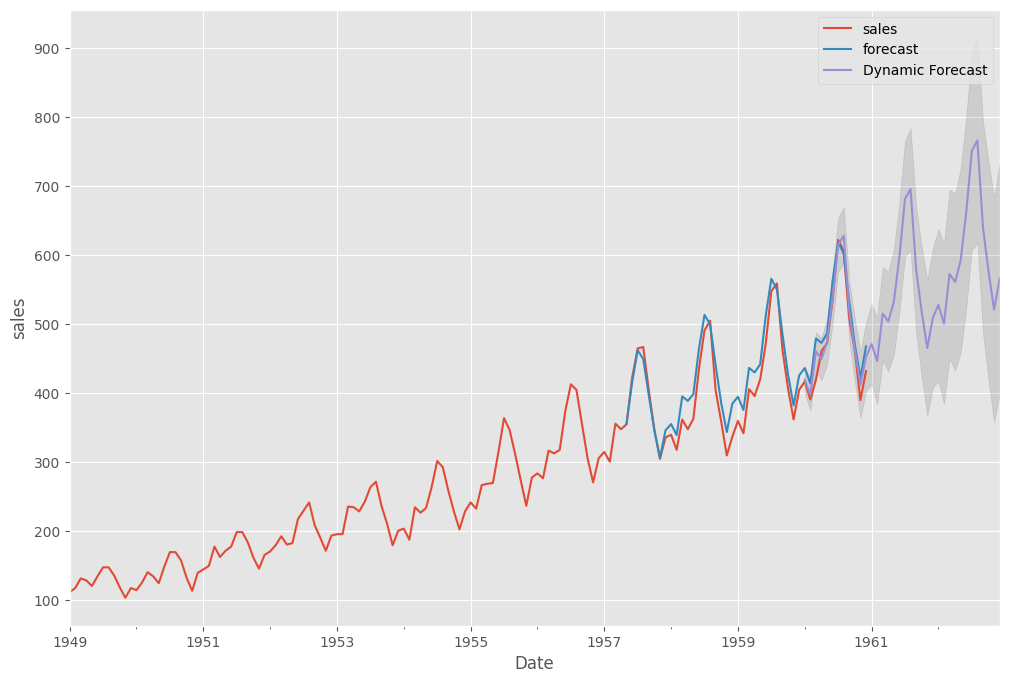

In [ ]:
ax = data.plot(figsize=(12, 8))
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('sales')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
data.describe()
data.shape

(144, 2)

In [ ]:
prediction = pred2.predicted_mean['1960-01-01':'1960-12-01'].values  #values will change
print(prediction)
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
print(truth)
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))


[419.49462124 397.83376136 460.85887469 449.45149082 474.55549876
 537.84873449 614.88469831 628.20908959 519.33619888 462.25438458
 412.16386888 452.66445213]
[417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432]
The Mean Absolute Percentage Error for the forecast of year 1960 is 2.81%
